In [ ]:
%load_ext autoreload
%load_ext autotime

time: 302 µs (started: 2024-12-12 20:09:51 -08:00)


In [2]:
import os
import sys
import time
import warnings
from bokeh.io import output_notebook

# Add WisIO to the path
sys.path.append(os.path.abspath("../"))

# Filter warnings
warnings.filterwarnings('ignore')

# Set the notebook to display Bokeh plots
output_notebook()

Loading BokehJS ...

time: 802 ms (started: 2024-12-12 20:09:51 -08:00)


In [3]:
analyzer = "dftracer"

run_dir = f".wisio/{analyzer}/{int(time.time())}"
bottleneck_dir = f"{run_dir}/bottlenecks"
checkpoint_dir = f"{run_dir}/checkpoints"

cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:46185"

checkpoint = False
exclude_characteristics = ['node_count', 'app_count', 'proc_count', 'file_count']
logical_view_types = False
percentile = 0.95
time_granularity = 1e6
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/cm1/APP/node-1/v1/RAW/*.pfw.gz"

app_metrics = [
    'intensity',
    'io_compute_per',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    'time_norm',
    'time_per',
    # 'u_checkpoint_io_time',
    # 'u_io_time_per',
    # 'u_read_io_time',
]
dataloader_metrics = [
    'intensity',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]
posix_metrics = [
    'intensity',
    'data_bw',
    'data_time_norm',
    'data_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]

app_view_types = ['proc_name', 'time_range']
dataloader_view_types = ['proc_name', 'time_range']
posix_view_types = ['proc_name', 'time_range']

time_view_type = 'time_range'
unoverlapped_posix_only = False

output_compact = False
output_group_behavior = False
output_max_bottlenecks = 1
output_root_only = True


time: 1.65 ms (started: 2024-12-12 20:09:52 -08:00)


In [5]:
# Parameters
analyzer = "dftracer"
bottleneck_dir = "/p/lustre3/iopp/wisio-bottlenecks/dftracer-cosmoflow-dlio-v100-node-16-v3-proc_name-time_range"
checkpoint = True
checkpoint_dir = "/p/lustre3/iopp/wisio-checkpoints/dftracer-cosmoflow-dlio-v100-node-16-v3-proc_name-time_range"
cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:36047"
logical_view_types = False
output_max_bottlenecks = 3
output_root_only = False
percentile = 0.6
run_dir = ".wisio/dftracer-cosmoflow-dlio-v100-node-16-v3-proc_name-time_range"
time_granularity = 3000000.0
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/cosmoflow/dlio-v100/node-16/v3/COMPACT/*.pfw.gz"

app_view_types = ["proc_name", "time_range"]
dataloader_view_types = ["proc_name", "time_range"]
posix_view_types = ["proc_name", "time_range"]


time: 1.19 ms (started: 2024-12-12 20:10:03 -08:00)


In [6]:
from distributed import Client
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from hydra.utils import instantiate
from wisio.cluster import ExternalCluster
from wisio.config import init_hydra_config_store
from wisio.utils.file_utils import ensure_dir

ensure_dir(run_dir)

with initialize(version_base=None, config_path=None):
    init_hydra_config_store()
    cfg = compose(
        config_name="config",
        overrides=[
            f"+analyzer={analyzer}",
            f"analyzer.bottleneck_dir={bottleneck_dir}",
            f"analyzer.checkpoint={checkpoint}",
            f"analyzer.checkpoint_dir={checkpoint_dir}",
            f"analyzer.time_granularity={time_granularity}",
            # f"cluster={cluster}",
            # f"cluster.restart_on_connect={cluster_restart_on_connect}",
            # f"cluster.scheduler_address={cluster_scheduler_address}",
            "cluster=external",
            "cluster.scheduler_address=tcp://127.0.0.1:46065",
            f"exclude_characteristics=[{','.join(exclude_characteristics)}]",
            f"hydra.run.dir={run_dir}",
            f"hydra.runtime.output_dir={run_dir}",
            f"logical_view_types={logical_view_types}",
            f"output.compact={output_compact}",
            f"output.group_behavior={output_group_behavior}",
            f"output.max_bottlenecks={output_max_bottlenecks}",
            f"output.root_only={output_root_only}",
            f"percentile={percentile}",
            f"trace_path={trace_path}",
        ],
        return_hydra_config=True,
    )
    HydraConfig.instance().set_config(cfg)
    cluster = instantiate(cfg.cluster)
    if isinstance(cluster, ExternalCluster):
        client = Client(cluster.scheduler_address)
        if cluster.restart_on_connect:
            client.restart()
    else:
        client = Client(cluster)
    analyzer = instantiate(cfg.analyzer)
    output = instantiate(cfg.output)

time: 4.32 s (started: 2024-12-12 20:10:04 -08:00)


In [7]:
client.dashboard_link

'http://127.0.0.1:8787/status'

time: 7.29 ms (started: 2024-12-12 20:10:08 -08:00)


In [8]:
client.restart()

<Client: 'tcp://127.0.0.1:46065' processes=0 threads=0, memory=0 B>

time: 4.7 s (started: 2024-12-12 20:10:08 -08:00)


In [9]:
from wisio.constants import Layer

result = analyzer.analyze_trace(
    trace_path=cfg.trace_path,
    bottleneck_rules=cfg.bottleneck_rules,
    exclude_bottlenecks=cfg.exclude_bottlenecks,
    exclude_characteristics=cfg.exclude_characteristics,
    logical_view_types=cfg.logical_view_types,
    percentile=cfg.percentile,
    metrics={
        'dlio': app_metrics,
        'compute': app_metrics,
        'dataloader': dataloader_metrics,
        'image': dataloader_metrics,
        'reader': dataloader_metrics,
        'checkpoint': dataloader_metrics,
        'posix': posix_metrics,
    },
    time_view_type=time_view_type,
    unoverlapped_posix_only=unoverlapped_posix_only,
    view_types={
        'dlio': app_view_types,
        'compute': app_view_types,
        'dataloader': dataloader_view_types,
        'image': dataloader_view_types,
        'reader': dataloader_view_types,
        'checkpoint': dataloader_view_types,
        'posix': posix_view_types,
    },
)

time: 17min 18s (started: 2024-12-12 20:10:13 -08:00)


In [10]:
traces, hlms, main_views, metric_boundaries, views, flat_views = result

time: 723 µs (started: 2024-12-12 20:27:32 -08:00)


In [12]:
checkpoint_dir

'/p/lustre3/iopp/wisio-checkpoints/dftracer-cosmoflow-dlio-v100-node-16-v3-proc_name-time_range'

time: 2.52 ms (started: 2024-12-12 20:36:13 -08:00)


In [11]:
traces.to_parquet(f"{checkpoint_dir}/_traces", write_metadata_file=True)

time: 33.8 s (started: 2024-12-12 20:27:32 -08:00)


In [19]:
traces['func_name'].value_counts().compute()

func_name
FileStorage.get_uri                      67109240
pread                                    31904065
__lxstat64                                6011776
close                                     2808474
open                                      2791936
TFReader._parse_image                     2623195
TFFramework.compute                       2621440
<module>.yield                            2620800
<module>.iter                             2620799
__xstat64                                 1803966
read                                       227200
opendir                                     83324
__xstat                                     68188
fclose                                      67472
fopen64                                     53264
readlink                                    35328
lseek64                                     21891
__fxstat64                                  19201
open64                                      17281
fopen                                   

time: 14.8 s (started: 2024-12-07 23:08:43 -08:00)


In [23]:
traces.query('cat.isin(["data_loader"])').groupby(['func_name'])['time'].sum().compute()

func_name
TFDataLoader.read    24018.157738
Name: time, dtype: double[pyarrow]

time: 14.6 s (started: 2024-12-07 23:12:43 -08:00)


In [24]:
traces.query('cat.isin(["reader"])').groupby(['func_name'])['time'].sum().compute()

func_name
TFReader._parse_image    2208.215413
Name: time, dtype: double[pyarrow]

time: 14.4 s (started: 2024-12-07 23:12:58 -08:00)


In [25]:
traces.query('cat.isin(["checkpoint"])').groupby(['func_name'])['time'].sum().compute()

func_name
TFCheckpointing.get_tensor    0.291004
Name: time, dtype: double[pyarrow]

time: 14.5 s (started: 2024-12-07 23:32:47 -08:00)


In [11]:
flat_views[('time_range',)][
    [
        'compute_time',
        'checkpoint_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'dataloader_time',
        'dataloader_sample_time',
        'posix_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        'u_dataloader_sample_time',
        'u_posix_time',
    ]
].sum()

compute_time                201.301015
checkpoint_time               0.291004
dlio_compute_time           280.277281
dlio_stall_time              20.925688
dataloader_time             188.287999
dataloader_sample_time             0.0
posix_time                   64.100765
u_checkpoint_time             0.291004
u_dataloader_time           188.287999
u_dataloader_sample_time           0.0
u_posix_time                 10.583237
dtype: double[pyarrow]

time: 5.97 ms (started: 2024-12-08 18:49:03 -08:00)


In [11]:
flat_views[('time_range',)][
    [
        'compute_time',
        'checkpoint_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'dataloader_time',
        'dataloader_sample_time',
        'posix_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        'u_dataloader_sample_time',
        'u_posix_time',
    ]
].sum()

compute_time                201.301015
checkpoint_time               0.291004
dlio_compute_time           280.277281
dlio_stall_time              20.925688
dataloader_time             188.287999
dataloader_sample_time             0.0
posix_time                   64.100765
u_checkpoint_time                  0.0
u_dataloader_time                  0.0
u_dataloader_sample_time           0.0
u_posix_time                  7.473961
dtype: double[pyarrow]

time: 6.75 ms (started: 2024-12-07 22:51:07 -08:00)


In [11]:
flat_views[('time_range',)][
    [
        'compute_time',
        'checkpoint_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'dataloader_time',
        'dataloader_sample_time',
        'posix_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        'u_dataloader_sample_time',
        'u_posix_time',
    ]
].sum()

compute_time                201.301015
checkpoint_time               0.591581
dlio_compute_time           280.277281
dlio_stall_time              20.925688
dataloader_time             188.288177
dataloader_sample_time             0.0
posix_time                   64.100765
u_checkpoint_time             0.591581
u_dataloader_time           188.288053
u_dataloader_sample_time           0.0
u_posix_time                 10.583237
dtype: double[pyarrow]

time: 5.67 ms (started: 2024-12-04 23:11:05 -08:00)


In [12]:
flat_views[('time_range',)].sort_index().to_csv('cosmoflow_node16_time_range.csv')

time: 69.1 ms (started: 2024-12-08 18:49:15 -08:00)


In [13]:
flat_views[('proc_name',)].sort_index().to_csv('cosmoflow_node16_proc_name.csv')

time: 6.29 s (started: 2024-12-08 18:49:16 -08:00)


In [14]:
flat_views[('proc_name', 'proc_id')].sort_index().to_csv('cosmoflow_node16_proc_id.csv')

time: 62.2 ms (started: 2024-12-08 18:49:22 -08:00)


In [15]:
flat_views[('proc_name', 'host_name')].sort_index().to_csv('cosmoflow_node16_host_name.csv')

time: 35.2 ms (started: 2024-12-08 18:49:22 -08:00)


In [16]:
import pandas as pd 
from wisio.metrics import set_metric_scores

time_range_view = pd.read_csv('cosmoflow_node16_time_range.csv').copy().set_index('time_range')
# time_range_view = pd.read_csv('cosmoflow_node4_proc_name.csv').copy().set_index('proc_name')
time_range_view.index = time_range_view.index.astype(str)

time_range_view['reader_r3_time'] = time_range_view['reader_time'].rolling(window=3).mean()
time_range_view['reader_r3_gauss_time'] = time_range_view['reader_time'].rolling(window=3, win_type='gaussian').mean(std=1)
time_range_view['reader_r3_hann_time'] = time_range_view['reader_time'].rolling(window=3, win_type='hann').mean()

time_range_view['reader_r3_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_r3_time'].sum()
time_range_view['reader_r3_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_r3_gauss_time'].sum()
time_range_view['reader_r3_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_r3_hann_time'].sum()

time_range_view['reader_r3_2_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_time'].sum()

time_range_view['reader_r3_time_norm'] = time_range_view['reader_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_gauss_time_norm'] = time_range_view['reader_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_hann_time_norm'] = time_range_view['reader_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

time_range_view['posix_read_r3_time'] = time_range_view['posix_read_time'].rolling(window=10).sum()
time_range_view['posix_read_r3_gauss_time'] = time_range_view['posix_read_time'].rolling(window=10, win_type='gaussian').sum(std=1)
time_range_view['posix_read_r3_hann_time'] = time_range_view['posix_read_time'].rolling(window=10, win_type='hann').sum()

time_range_view['posix_read_r3_time_per'] = time_range_view['posix_read_r3_time'] / time_range_view['posix_read_r3_time'].sum()
time_range_view['posix_read_r3_gauss_time_per'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view['posix_read_r3_gauss_time'].sum()
time_range_view['posix_read_r3_hann_time_per'] = time_range_view['posix_read_r3_hann_time'] / time_range_view['posix_read_r3_hann_time'].sum()

time_range_view['posix_read_r3_time_norm'] = time_range_view['posix_read_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_gauss_time_norm'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_hann_time_norm'] = time_range_view['posix_read_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

# time_range_view['dlio_compute_util'] = time_range_view['dlio_compute_time'].astype(
#     float
# ) / (
#     time_range_view['dlio_compute_time'].astype(float)
#     + time_range_view['dlio_stall_time'].astype(float)
#     # + time_range_view['checkpoint_time'].astype(float)
# )

time_range_view = set_metric_scores(time_range_view)
# time_range_view['dlio_compute_util_score'] = 8 - time_range_view['dlio_compute_util_score']
# time_range_view['dlio_compute_util_score'] = time_range_view['dlio_compute_util_score'].mask(time_range_view['dlio_compute_time'] == 0, pd.NA)

dlio_cols = ['dlio_compute_util_score'] # [col for col in time_range_view.columns if 'dlio_' in col and col.endswith('_score')]
dataloader_cols = [col for col in time_range_view.columns if 'dataloader_' in col and col.endswith('_score')]
checkpoint_cols = [col for col in time_range_view.columns if 'checkpoint_' in col and col.endswith('_score')]
posix_cols = [col for col in time_range_view.columns if 'posix_' in col and col.endswith('_score')]
# norm_cols = [col for col in time_range_view.columns if '_score' in col]
# norm_cols = ['dlio_compute_util_score'] + norm_cols
norm_cols = dlio_cols + dataloader_cols + checkpoint_cols + posix_cols

norm_cols = [col for col in norm_cols if 'slope' not in col]

norm_scores = time_range_view[norm_cols]
norm_scores

,dlio_compute_util_score,dataloader_bw_score,dataloader_compute_per_score,dataloader_count_per_score,dataloader_intensity_score,dataloader_ops_rank_score,dataloader_sample_time_norm_score,dataloader_sample_time_per_score,dataloader_time_norm_score,dataloader_time_per_score,...,u_posix_read_time_norm_score,u_posix_read_time_per_score,u_posix_seek_time_norm_score,u_posix_seek_time_per_score,u_posix_stat_time_norm_score,u_posix_stat_time_per_score,u_posix_time_norm_score,u_posix_time_per_score,u_posix_write_time_norm_score,u_posix_write_time_per_score
time_range,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,3,1,3,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,3,1,2,1,3
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,2,1,2,1,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,3,1,2,1,3,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 282 ms (started: 2024-12-08 18:49:24 -08:00)


In [17]:
import pandas as pd

norm_scores_all = norm_scores.copy()
for col in norm_cols:
    norm_scores2 = norm_scores.copy()
    norm_scores2['score_col'] = col
    norm_scores2['score'] = norm_scores2[col]
    norm_scores_all = pd.concat([norm_scores_all, norm_scores2])
norm_scores_all.drop(columns=norm_cols).dropna()

,score_col,score
time_range,,
0,dlio_compute_util_score,0
1,dlio_compute_util_score,0
2,dlio_compute_util_score,0
3,dlio_compute_util_score,0
4,dlio_compute_util_score,0
...,...,...
242,u_posix_write_time_per_score,0
243,u_posix_write_time_per_score,0
244,u_posix_write_time_per_score,0


time: 2.01 s (started: 2024-12-08 18:49:24 -08:00)


In [21]:
from math import pi

import pandas as pd

from bokeh.models import BasicTicker, PrintfTickFormatter
from bokeh.plotting import figure, show
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import linear_cmap
from bokeh.palettes import RdYlGn, Reds, TolYlOrBr
from bokeh.io import output_notebook

output_notebook()

VAL_COL = 'proc_id'

years = list(time_range_view.index.astype(str))
months = list(reversed(norm_cols))

# reshape to 1D array or rates with a month and year for each row.
df = norm_scores_all.drop(
    columns=norm_cols
).reset_index().dropna()  # pd.DataFrame(data.stack(), columns=['rate']).reset_index()

# this is the colormap from the original NYTimes plot
colors = [
    "#75968f",
    "#a5bab7",
    "#c9d9d3",
    "#e2e2e2",
    "#dfccce",
    "#ddb7b1",
    "#cc7878",
    "#933b41",
    "#550b1d",
]
mapper = linear_cmap(
    field_name="score",
    palette=Reds[8][::-1],  # Green-to-Red palette with 11 steps
    low=0,
    high=8,
)

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(
    # title=f"US Unemployment ({years[0]} - {years[-1]})",
    x_range=years,
    y_range=months,
    x_axis_location="above",
    width=900,
    height=400,
    tools=TOOLS,
    toolbar_location='below',
    tooltips=[('date', '@time_range'), ('score', '@score%')],
)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3

r = p.rect(
    x="time_range",
    y="score_col",
    width=1,
    height=1,
    source=df,
    fill_color=mapper, # linear_cmap("score", colors, low=0, high=8),
    line_color=None,
)

p.add_layout(
    r.construct_color_bar(
        major_label_text_font_size="7px",
        ticker=BasicTicker(desired_num_ticks=len(colors)),
        formatter=PrintfTickFormatter(format="%d%%"),
        label_standoff=6,
        border_line_color=None,
        padding=5,
    ),
    'right',
)

show(p)

Loading BokehJS ...

time: 158 ms (started: 2024-12-08 18:50:48 -08:00)


Feature Importances (Random Forest):
posix_read_ops_rank_score     0.250958
posix_compute_per_score       0.139960
posix_write_ops_rank_score    0.116780
posix_ops_rank_score          0.057575
compute_intensity_score       0.055067
                                ...   
posix_ipc_time_per_score      0.000000
posix_ipc_time_norm_score     0.000000
posix_ipc_ops_rank_score      0.000000
posix_ipc_count_per_score     0.000000
u_reader_time_per_score       0.000000
Length: 145, dtype: float64


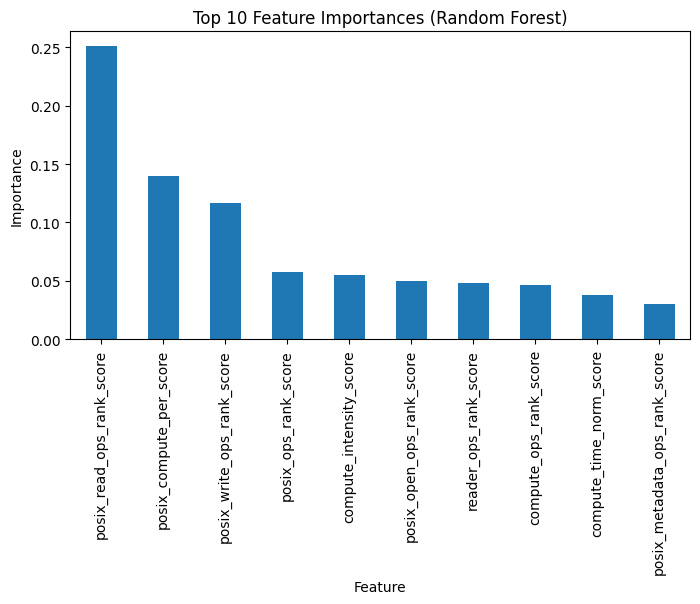

time: 292 ms (started: 2024-12-08 18:55:13 -08:00)


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Splitting data into features (X) and target (y)
# df = df.dropna()
df = pd.read_csv('cosmoflow_node16_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display top features
print("Feature Importances (Random Forest):")
print(feature_importances)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()


Top correlations with 'dlio_compute_util_score':
dlio_compute_util_score               1.000000
posix_compute_per_score               0.454296
posix_ops_rank_score                  0.434057
posix_time_norm_score                 0.428507
u_posix_read_time_norm_score          0.428045
                                        ...   
u_reader_preprocess_time_per_score         NaN
u_reader_sample_time_norm_score            NaN
u_reader_sample_time_per_score             NaN
u_reader_time_norm_score                   NaN
u_reader_time_per_score                    NaN
Name: dlio_compute_util_score, Length: 146, dtype: float64


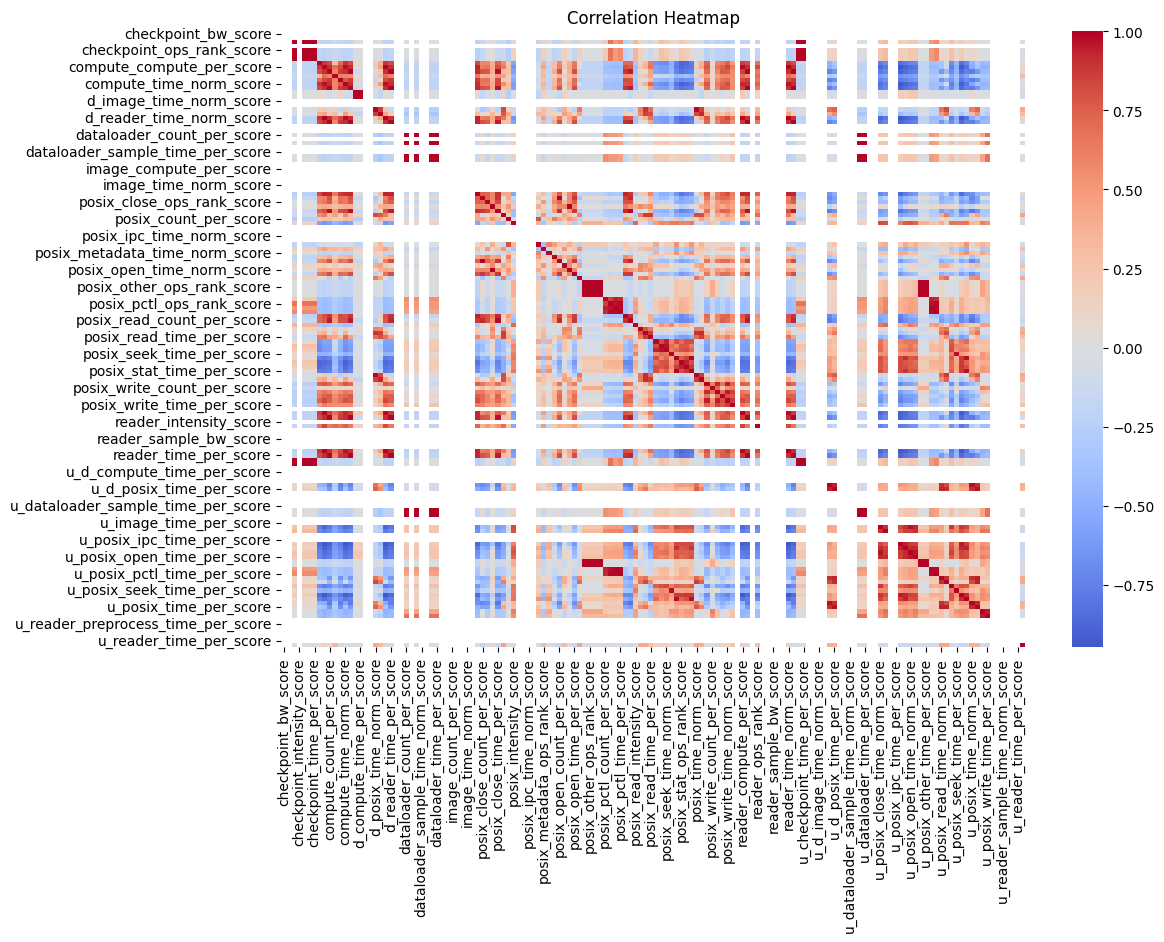

time: 791 ms (started: 2024-12-08 18:55:27 -08:00)


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your dataframe containing the scores

df = pd.read_csv('cosmoflow_node16_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target]


# df = norm_scores.copy()

# Calculate correlation matrix
correlation_matrix = df[score_cols].copy().corr()

# Focus on correlations with 'dlio_compute_util_score'
target_correlation = correlation_matrix[target].sort_values(ascending=False)

# Print correlations
print("Top correlations with 'dlio_compute_util_score':")
print(target_correlation)

# Plot a heatmap for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

# Optional: Heatmap focusing only on top 10 correlated features
# top_features = target_correlation.index[:10]  # Top 10 features
# plt.figure(figsize=(10, 6))
# sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', center=0, cbar=True)
# plt.title('Heatmap of Top 10 Correlated Features with dlio_compute_util_score')
# plt.show()


<Axes: >

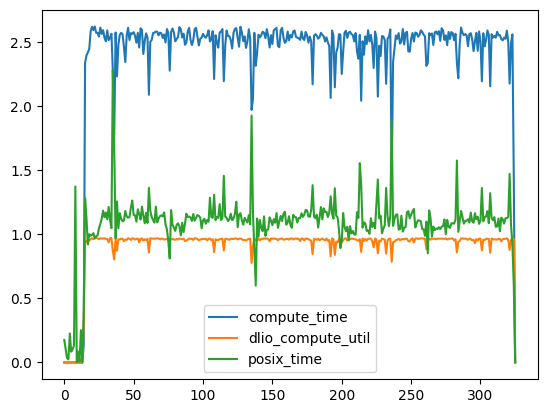

time: 162 ms (started: 2024-12-02 00:50:08 -08:00)


In [21]:
df2.sort_index()[['compute_time', 'dlio_compute_util', 'posix_time']].plot()

<Axes: xlabel='time_range'>

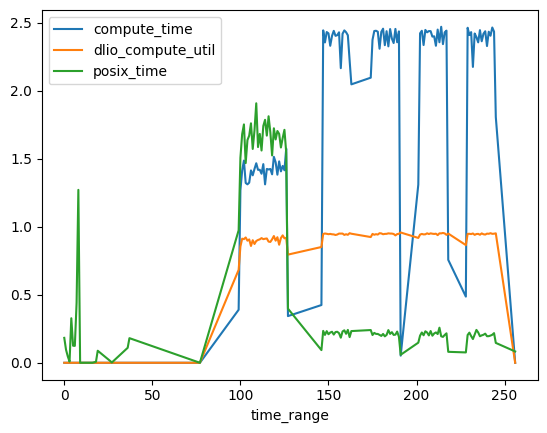

time: 152 ms (started: 2024-12-02 00:50:20 -08:00)


In [22]:
flat_views[('time_range',)].sort_index()[['compute_time', 'dlio_compute_util', 'posix_time']].plot()

In [1]:
import pandas as pd

df3 = pd.read_csv('cosmoflow_node4_proc_name.csv')

<Axes: >

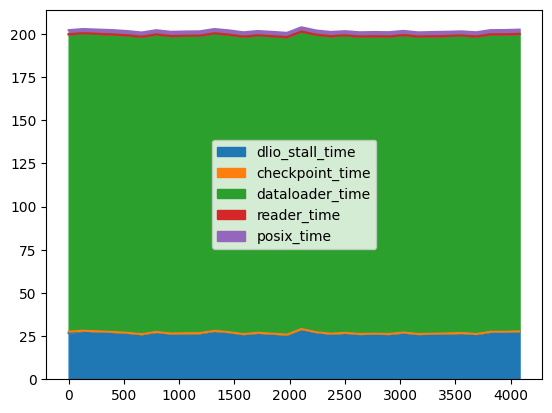

In [17]:
df3.query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'reader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot(kind='area') #kind='bar', stacked=True)

In [5]:
df4 = pd.read_csv('cosmoflow_node16_proc_name.csv')

<Axes: >

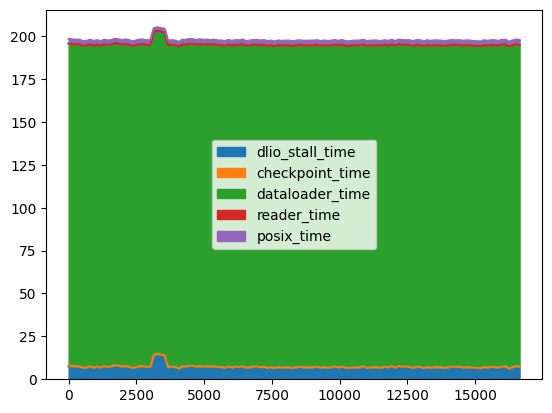

In [16]:
df4.query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'reader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot(kind='area') #kind='bar', stacked=True)

<Axes: xlabel='host_name'>

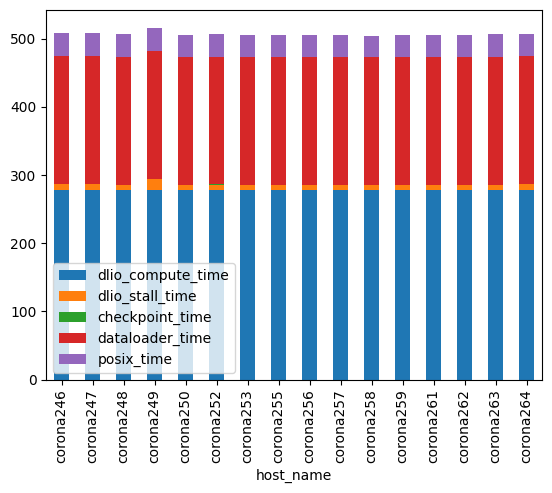

time: 813 ms (started: 2024-12-02 01:13:18 -08:00)


In [17]:
flat_views[('proc_name', 'host_name')].sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot(kind='bar', stacked=True)

In [18]:
import pandas as pd

<Axes: >

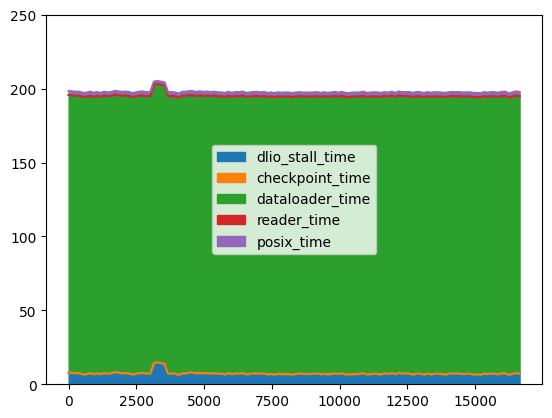

In [19]:
pd.read_csv('cosmoflow_node16_proc_name.csv').query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'reader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot(kind='area', ylim=(0, 250))

In [22]:
len(pd.read_csv('cosmoflow_node16_time_range.csv'))

120

time: 18.7 ms (started: 2024-12-04 23:13:51 -08:00)


<Axes: xlabel='time_range'>

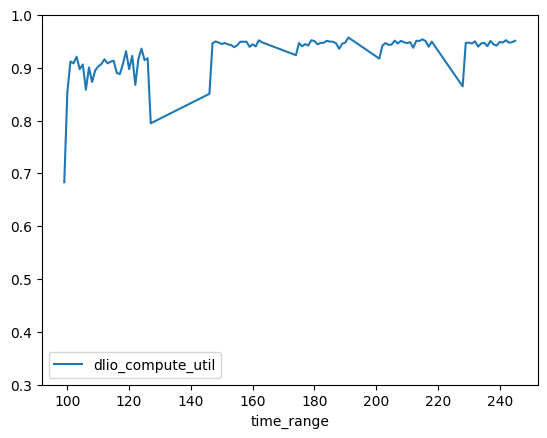

time: 155 ms (started: 2024-12-04 23:15:33 -08:00)


In [24]:
pd.read_csv('cosmoflow_node16_time_range.csv').set_index('time_range')[
    [
        # 'compute_time',
        # 'checkpoint_time',
        'dlio_compute_util',
        # 'dlio_stall_time',
        # 'dataloader_time',
        # 'dataloader_sample_time',
        # 'posix_time',
        # 'u_checkpoint_time',
        # 'u_dataloader_time',
        # 'u_dataloader_sample_time',
        # 'u_posix_time',
    ]
].plot(ylim=(0.3, 1))

In [ ]:
flat_views[('proc_name',)].sort_index()[
    ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
].plot(kind='bar', stacked=True)

In [16]:
flat_views[('time_range',)].query('dlio_stall_time > 0')

,checkpoint_bw,checkpoint_count,checkpoint_count_per,checkpoint_intensity,checkpoint_intensity_rank,checkpoint_ops,checkpoint_ops_rank,checkpoint_ops_slope,checkpoint_size,checkpoint_size_max,...,u_posix_time_per,u_posix_write_time,u_posix_write_time_norm,u_posix_write_time_per,u_reader_sample_time,u_reader_sample_time_norm,u_reader_sample_time_per,u_reader_time,u_reader_time_norm,u_reader_time_per
time_range,,,,,,,,,,,,,,,,,,,,,
99,NaN,0.0,0.0,0.0,0.504167,NaN,1.889764,NaN,0,0,...,0.05517,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
100,NaN,0.0,0.0,0.0,0.504167,NaN,1.889764,NaN,0,0,...,0.022551,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
101,NaN,0.0,0.0,0.0,0.504167,NaN,1.889764,NaN,0,0,...,0.025252,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
102,NaN,0.0,0.0,0.0,0.504167,NaN,1.889764,NaN,0,0,...,0.025108,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
103,NaN,0.0,0.0,0.0,0.504167,NaN,1.889764,NaN,0,0,...,0.013802,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,NaN,0.0,0.0,0.0,0.504167,NaN,1.889764,NaN,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
242,NaN,0.0,0.0,0.0,0.504167,NaN,1.889764,NaN,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
243,NaN,0.0,0.0,0.0,0.504167,NaN,1.889764,NaN,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN


time: 134 ms (started: 2024-12-01 23:02:44 -08:00)


In [12]:
main_views['APP'].query('stall_time > 0.5').compute()

,,time,count,size_min,size_max,size,checkpoint_time,compute_time,read_time,stall_time
proc_name,time_range,,,,,,,,,
app#corona246#935270#935270,99,2.071799,197,324,1507,3469,0.0,0.386659,0.0,0.661945
app#corona247#411125#411125,99,2.071301,197,324,1507,3469,0.0,0.386692,0.0,0.547753
app#corona252#417131#417131,99,2.071945,197,324,1506,3468,0.0,0.386679,0.0,0.554293
app#corona253#410994#410994,99,2.064725,197,324,1506,3468,0.0,0.386591,0.0,0.595785
app#corona255#854701#854701,99,2.057637,197,324,1506,3468,0.0,0.386566,0.0,0.506035
app#corona255#854705#854705,99,2.071181,197,324,1506,3468,0.0,0.386676,0.0,0.535287
app#corona256#783782#783782,99,2.077035,197,324,1506,3468,0.0,0.386664,0.0,0.510435
app#corona258#774178#774178,99,2.067104,197,324,1506,3468,0.0,0.386709,0.0,0.502636
app#corona259#767814#767814,99,2.072163,197,324,1506,3468,0.0,0.387191,0.0,0.527453


time: 68.7 ms (started: 2024-11-30 15:36:04 -08:00)


In [13]:
app_main_view = main_views['APP'].compute()
app_main_view

time  count  size_min  size_max  \
proc_name                   time_range                                        
app#corona246#935267#935267 1           0.057572   1745      3131      3251   
                            9           0.344605  47984         0         0   
                            10          0.377563  52716         0         0   
                            11          0.378504  52687         0         0   
                            13          0.378194  52668         0         0   
...                                          ...    ...       ...       ...   
app#corona264#800477#801695 244         0.025942     34         0         0   
app#corona264#800477#801712 229         0.042229     56         0         0   
                            243         0.035066     45         0         0   
app#corona264#800477#801720 240         0.025778     31         0         0   
app#corona264#800477#801728 240         0.035528     46         0         0   

                                        size  checkpoint_time  compute_time  \
proc_name                   time_range                                        
app#corona246#935267#935267 1           3411              0.0           0.0   
                            9              0              0.0           0.0   
                            10             0              0.0           0.0   
                            11             0              0.0           0.0   
                            13             0              0.0           0.0   
...                                      ...              ...           ...   
app#corona264#800477#801695 244            0              0.0           0.0   
app#corona264#800477#801712 229            0              0.0           0.0   
                            243            0              0.0           0.0   
app#corona264#800477#801720 240            0              0.0           0.0   
app#corona264#800477#801728 240            0              0.0           0.0   

                                        read_time  stall_time  
proc_name                   time_range                         
app#corona246#935267#935267 1                 0.0         0.0  
                            9                 0.0         0.0  
                            10                0.0         0.0  
                            11                0.0         0.0  
                            13                0.0         0.0  
...                                           ...         ...  
app#corona264#800477#801695 244          0.025942         0.0  
app#corona264#800477#801712 229          0.042229         0.0  
                            243          0.035066         0.0  
app#corona264#800477#801720 240          0.025778         0.0  
app#corona264#800477#801728 240          0.035528         0.0  

[327056 rows x 9 columns]

time: 133 ms (started: 2024-11-30 15:36:17 -08:00)


In [22]:
app_main_view = app_main_view.eval('compute_util = compute_time / (compute_time + stall_time)')
app_main_view

time  count  size_min  size_max  \
proc_name                   time_range                                        
app#corona246#935267#935267 1           0.057572   1745      3131      3251   
                            9           0.344605  47984         0         0   
                            10          0.377563  52716         0         0   
                            11          0.378504  52687         0         0   
                            13          0.378194  52668         0         0   
...                                          ...    ...       ...       ...   
app#corona264#800477#801695 244         0.025942     34         0         0   
app#corona264#800477#801712 229         0.042229     56         0         0   
                            243         0.035066     45         0         0   
app#corona264#800477#801720 240         0.025778     31         0         0   
app#corona264#800477#801728 240         0.035528     46         0         0   

                                        size  checkpoint_time  compute_time  \
proc_name                   time_range                                        
app#corona246#935267#935267 1           3411              0.0           0.0   
                            9              0              0.0           0.0   
                            10             0              0.0           0.0   
                            11             0              0.0           0.0   
                            13             0              0.0           0.0   
...                                      ...              ...           ...   
app#corona264#800477#801695 244            0              0.0           0.0   
app#corona264#800477#801712 229            0              0.0           0.0   
                            243            0              0.0           0.0   
app#corona264#800477#801720 240            0              0.0           0.0   
app#corona264#800477#801728 240            0              0.0           0.0   

                                        read_time  stall_time  compute_util  
proc_name                   time_range                                       
app#corona246#935267#935267 1                 0.0         0.0           NaN  
                            9                 0.0         0.0           NaN  
                            10                0.0         0.0           NaN  
                            11                0.0         0.0           NaN  
                            13                0.0         0.0           NaN  
...                                           ...         ...           ...  
app#corona264#800477#801695 244          0.025942         0.0           NaN  
app#corona264#800477#801712 229          0.042229         0.0           NaN  
                            243          0.035066         0.0           NaN  
app#corona264#800477#801720 240          0.025778         0.0           NaN  
app#corona264#800477#801728 240          0.035528         0.0           NaN  

[327056 rows x 10 columns]

time: 29.5 ms (started: 2024-11-30 15:39:01 -08:00)


In [23]:
app_main_view[app_main_view['compute_util'] < 0.8]

,,time,count,size_min,size_max,size,checkpoint_time,compute_time,read_time,stall_time,compute_util
proc_name,time_range,,,,,,,,,,
app#corona246#935267#935267,99,2.071626,199,484,1688,3810,0.0,0.386653,0.0,0.435294,0.470411
app#corona246#935268#935268,99,2.075963,197,324,1507,3469,0.0,0.387156,0.0,0.448231,0.463445
app#corona246#935270#935270,99,2.071799,197,324,1507,3469,0.0,0.386659,0.0,0.661945,0.368737
app#corona246#935276#935276,99,2.081752,197,324,1507,3469,0.0,0.386692,0.0,0.405722,0.487992
app#corona246#935277#935277,99,2.070564,197,324,1507,3469,0.0,0.386704,0.0,0.449236,0.462598
...,...,...,...,...,...,...,...,...,...,...,...
app#corona264#800473#800473,99,2.079941,197,324,1507,3469,0.0,0.386704,0.0,0.552775,0.411615
app#corona264#800474#800474,99,2.079627,197,324,1507,3469,0.0,0.386721,0.0,0.354329,0.521855
app#corona264#800475#800475,99,2.068961,197,324,1507,3469,0.0,0.386676,0.0,0.545168,0.414958


time: 17.4 ms (started: 2024-11-30 15:39:02 -08:00)


In [24]:
dl_main_view = main_views['DATALOADER'].compute()
dl_main_view

time  count  size_min  size_max  \
proc_name                   time_range                                        
app#corona246#935267#935267 1           0.057572   1745      3131      3251   
                            9           0.000038      1         0         0   
                            19          0.088446   3283        48      1881   
                            99          0.002088     34       484      1688   
                            101          0.00001      2       557       853   
...                                          ...    ...       ...       ...   
app#corona264#800477#801695 244         0.025942     34         0         0   
app#corona264#800477#801712 229         0.042229     56         0         0   
                            243         0.035066     45         0         0   
app#corona264#800477#801720 240         0.025778     31         0         0   
app#corona264#800477#801728 240         0.035528     46         0         0   

                                         size  image_size  image_size_max  \
proc_name                   time_range                                      
app#corona246#935267#935267 1            3411           0               0   
                            9               0           0               0   
                            19          53079           0               0   
                            99           3810         861              41   
                            101         74910       37250             324   
...                                       ...         ...             ...   
app#corona264#800477#801695 244             0           0               0   
app#corona264#800477#801712 229             0           0               0   
                            243             0           0               0   
app#corona264#800477#801720 240             0           0               0   
app#corona264#800477#801728 240             0           0               0   

                                        image_size_min  
proc_name                   time_range                  
app#corona246#935267#935267 1                        0  
                            9                        0  
                            19                       0  
                            99                       1  
                            101                    176  
...                                                ...  
app#corona264#800477#801695 244                      0  
app#corona264#800477#801712 229                      0  
                            243                      0  
app#corona264#800477#801720 240                      0  
app#corona264#800477#801728 240                      0  

[325857 rows x 8 columns]

time: 128 ms (started: 2024-11-30 15:39:38 -08:00)


In [25]:
dl_main_view[dl_main_view['image_size'] > 0]

time  count  size_min  size_max  \
proc_name                   time_range                                        
app#corona246#935267#935267 99          0.002088     34       484      1688   
                            101          0.00001      2       557       853   
                            102         0.000005      1       854      1166   
                            103          0.00001      2      1169      1443   
                            105         0.000005      1      1721      1997   
...                                          ...    ...       ...       ...   
app#corona263#801187#801187 122              0.0      0      6580      6890   
app#corona263#801192#801192 233              0.0      0      2002      2486   
app#corona264#800470#800470 230              0.0      0       592      1076   
                            244              0.0      0      7346      7832   
app#corona264#800475#800475 239              0.0      0      4912      5402   

                                           size  image_size  image_size_max  \
proc_name                   time_range                                        
app#corona246#935267#935267 99             3810         861              41   
                            101           74910       37250             324   
                            102          126746       63271             481   
                            103          152348       75969             619   
                            105          230111      114953             896   
...                                         ...         ...             ...   
app#corona263#801187#801187 122         1050660      525330            3445   
app#corona263#801192#801192 233          545292      272646            1243   
app#corona264#800470#800470 230          202662      101331             538   
                            244         1851716      925858            3916   
app#corona264#800475#800475 239         1268622      634311            2701   

                                        image_size_min  
proc_name                   time_range                  
app#corona246#935267#935267 99                       1  
                            101                    176  
                            102                    325  
                            103                    482  
                            105                    758  
...                                                ...  
app#corona263#801187#801187 122                   3290  
app#corona263#801192#801192 233                   1001  
app#corona264#800470#800470 230                    296  
                            244                   3673  
app#corona264#800475#800475 239                   2456  

[12928 rows x 8 columns]

time: 17.7 ms (started: 2024-11-30 15:39:53 -08:00)


In [8]:
analyzer.write_bottlenecks(result.flat_bottlenecks)

time: 567 ms (started: 2024-11-11 12:53:13 -08:00)


In [9]:
output.handle_result(metrics=[], result=result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  App Time  Runtime: 769.93 seconds (100%)                                                                       │
│            ├── Application I/O Time: 0.00 seconds (0.00%)                                                       │
│            ├── Checkpoint I/O Time: 0.00 seconds (0.00%)                                                        │
│            ├── Compute Time: 201.30 seconds (26.15%)                                                            │
│            ├── I/O Time: 64.10 seconds (8.33%)                                                                  │
│            ├── Read I/O Time: 0.00 seconds (0.00%)                                                              │
│            ├── Time: 1085.87 seconds (141.04%)                                                                  │
│            ├── Unoverlapped Application I/O Time: 0.00 seconds (0.00%)                                          │
│            ├── Unoverlapped Checkpoint I/O Time: 0.00 seconds (0.00%)                                           │
│            ├── Unoverlapped Compute Time: 147.78 seconds (19.19%)                                               │
│            ├── Unoverlapped I/O Time: 10.58 seconds (1.37%)                                                     │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 201.30 seconds (26.15%)                                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭──────────────────────────────────────── DATALOADER I/O Characteristics ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime         769.93 seconds                                                                                 │
│  I/O Time        64.10 seconds (100%)                                                                           │
│                  ├── Read: 49.50 seconds (77.22%)                                                               │
│                  ├── Write: 0.00 seconds (0.01%)                                                                │
│                  └── Metadata: 17.28 seconds (26.96%)                                                           │
│  I/O Ops.        45,940,484 ops                                                                                 │
│                  ├── Read - 32,131,265 ops (69.94%)                                                             │
│                  ├── Write - 4,217 ops (0.01%)                                                                  │
│                  └── Metadata - 13,633,450 ops (29.68%)                                                         │
│  I/O Size        6.76 TiB                             

time: 43.2 ms (started: 2024-11-11 12:53:14 -08:00)


In [10]:
bottlenecks = analyzer.read_bottlenecks()

time: 24.7 ms (started: 2024-11-11 12:53:14 -08:00)


In [11]:
from bokeh.io import show
from wisio.plots import plot_bottleneck_summary

show(plot_bottleneck_summary(bottlenecks, groupby=('layer', 'view_name')))

time: 531 ms (started: 2024-11-11 12:53:14 -08:00)


In [12]:
show(plot_bottleneck_summary(bottlenecks, groupby=('layer', 'view_name', 'metric')))

time: 464 ms (started: 2024-11-11 12:53:14 -08:00)
